In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['olid-training-v1.0.tsv',
 'olid-annotation.txt',
 'testset-levela.tsv',
 'labels-levela.csv',
 'Colab Notebooks',
 '.ipynb_checkpoints',
 'output_Bayes_learning.csv',
 'output_RandomForest_learning.csv',
 'Untitled0.ipynb']

In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
import re
import matplotlib.pyplot as plt

label_to_number_a = {'OFF':0,'NOT':1}
def clean_data(tweet):
    splitted_tweet = tweet.lower().split()
    clean_tweet = []
    previous_word = None
    user_count = 0
    for word in splitted_tweet:
        #if word not in spacy_stopwords:
        word = re.sub("[#@]","",word)
        word = re.sub("!"," !",word)
        word = re.sub("[?]"," ?",word)
        
        if(word == "user"):
          user_count += 1
          
        if(word == "user" and previous_word == "user"):
          pass
        else:
          clean_tweet.append(word)
          
        previous_word = word
          
    return " ".join(clean_tweet), user_count
#Deal with the dataset
def read(testfiletsv):
    plt.figure(figsize = (12,4))
    plt.subplot(131)
    a=pd.read_csv(testfiletsv, delimiter='\t',)
    cat_a = Counter(a["subtask_a"])
    plt.bar(list(cat_a.keys()), list(cat_a.values()))
    plt.xticks(range(len(cat_a)), label_to_number_a)
    plt.title("Distribition of labels in subtask A");
    #since the distribution is not equal,we just choose 4000 from both sample
    dfOFF=a[a["subtask_a"] == "OFF"].sample(n=4000, random_state=3)
    dfNOT = a[a["subtask_a"] == "NOT"].sample(n=4000, random_state=2)
    #To prevent undersampling or Oversampling, we choose equal size of results
    dfPartial = dfOFF.append(dfNOT)
    return dfPartial
    

In [18]:
#First Method,Let us try Bays_learning method first
def  learning(dfPartial):  
    train_reviews, test_reviews, train_tags, test_tags = train_test_split(dfPartial["tweet"],dfPartial["subtask_a"],test_size=0.1, random_state=3,             
                                                          stratify=dfPartial["subtask_a"])
    #we splite the training and testing datasets

    train_tags = train_tags.to_numpy()
    train_reviews = train_reviews.to_numpy()
    test_tags = test_tags.to_numpy()
    test_reviews = test_reviews.to_numpy()
    #convertion and normalization deal with data

    count_vect = CountVectorizer()
    train_counts = count_vect.fit_transform(train_reviews)
    negTrain=0;
    posTrain=0;
    posTest=0;
    negTest=0;
    trainSize = 7200;
    testSize = 800;
    #Training process
    for i in range(trainSize):
        if (train_tags[i] == "OFF"):
            posTrain+=1
        if (train_tags[i] == "NOT"):
            negTrain+=1;     
    for i in range(testSize):
        if (test_tags[i] == "OFF"):
            posTest+=1
        if (test_tags[i] == "NOT"):
            negTest+=1;

    return(train_counts, train_tags,count_vect)  
def Bayes_learning_result(train_counts, train_tags,count_vect,b):
    sentence=b['tweet']
    test_reviews_counts = count_vect.transform(sentence)
    clf = MultinomialNB().fit(train_counts, train_tags)  
    test_reviews_counts = count_vect.transform(sentence)
    # Predict the results
    prediction = clf.predict(test_reviews_counts)
    # Print the first ten predictions
    result=[]
    for idnum,docTest, categoryTest in zip(b['id'],b['tweet'], prediction):   
        #print('%r => %s\n' % (docTest, categoryTest))
        result.append([idnum,docTest, categoryTest])
    return(result)
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


        id                                              tweet task1
0    15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   OFF
1    27014  #ConstitutionDay is revered by Conservatives, ...   OFF
2    30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...   NOT
3    13876  #Watching #Boomer getting the news that she is...   NOT
4    60133  #NoPasaran: Unity demo to oppose the far-right...   OFF
..     ...                                                ...   ...
855  73439  #DespicableDems lie again about rifles. Dem Di...   OFF
856  25657  #MeetTheSpeakers 🙌 @USER will present in our e...   NOT
857  67018  3 people just unfollowed me for talking about ...   OFF
858  50665  #WednesdayWisdom Antifa calls the right fascis...   NOT
859  24583      #Kavanaugh typical #liberals , #Democrats URL   OFF

[860 rows x 3 columns]


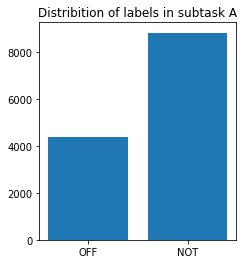

In [19]:
a=read('olid-training-v1.0.tsv')

for i in a["tweet"]:
  a["tweet"][i]=clean_data(i)
train_counts, train_tags,count_vect=learning(a)
b=pd.read_csv('testset-levela.tsv', delimiter='\t',)
result=Bayes_learning_result(train_counts, train_tags,count_vect,b)
Bayes_learning_final=pd.DataFrame(result, columns=['id','tweet','task1'])
print(Bayes_learning_final)


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
def  Randomforest_learning(train_counts, train_tags,count_vect,b):
    sentence=b['tweet']
    test_reviews_counts = count_vect.transform(sentence)
    classifier = RandomForestClassifier(max_depth=800, min_samples_split=5)
    params = {'n_estimators': [n for n in range(50,200,50)], 'criterion':['gini','entropy'], }
    classifier = GridSearchCV(classifier, params, cv=3, n_jobs=4)
    classifier.fit(train_counts, train_tags)
    # Predict the results
    prediction = classifier.predict(test_reviews_counts)
    # Print the first ten predictions
    result=[]
    for idnum,docTest, categoryTest in zip(b['id'],b['tweet'], prediction):   
        #print('%r => %s\n' % (docTest, categoryTest))
        result.append([idnum,docTest, categoryTest])
    return(result)

In [22]:
train_counts, train_tags,count_vect=learning(a)
b=pd.read_csv('testset-levela.tsv', delimiter='\t',)
result=Randomforest_learning(train_counts, train_tags,count_vect,b)
Randomforest_learning_final=pd.DataFrame(result, columns=['id','tweet','task1'])
print(Randomforest_learning_final)

        id                                              tweet task1
0    15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   OFF
1    27014  #ConstitutionDay is revered by Conservatives, ...   NOT
2    30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...   NOT
3    13876  #Watching #Boomer getting the news that she is...   NOT
4    60133  #NoPasaran: Unity demo to oppose the far-right...   NOT
..     ...                                                ...   ...
855  73439  #DespicableDems lie again about rifles. Dem Di...   NOT
856  25657  #MeetTheSpeakers 🙌 @USER will present in our e...   NOT
857  67018  3 people just unfollowed me for talking about ...   OFF
858  50665  #WednesdayWisdom Antifa calls the right fascis...   OFF
859  24583      #Kavanaugh typical #liberals , #Democrats URL   NOT

[860 rows x 3 columns]


In [23]:
from sklearn.svm import SVC
def  SVM(train_counts, train_tags,count_vect,b):
    sentence=b['tweet']
    test_reviews_counts = count_vect.transform(sentence)
    classifier = SVC()
    classifier = GridSearchCV(classifier, {'C':[0.001, 0.01, 0.1, 1, 10]}, cv=3, n_jobs=4)
    classifier.fit(train_counts, train_tags)
    # Predict the results
    prediction = classifier.predict(test_reviews_counts)
    # Print the first ten predictions
    result=[]
    for idnum,docTest, categoryTest in zip(b['id'],b['tweet'], prediction):   
        #print('%r => %s\n' % (docTest, categoryTest))
        result.append([idnum,docTest, categoryTest])
    return(result)

In [24]:
train_counts, train_tags,count_vect=learning(a)
b=pd.read_csv('testset-levela.tsv', delimiter='\t',)
result=SVM(train_counts, train_tags,count_vect,b)
SVM_final=pd.DataFrame(result, columns=['id','tweet','task1'])
print(SVM_final)

        id                                              tweet task1
0    15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   OFF
1    27014  #ConstitutionDay is revered by Conservatives, ...   NOT
2    30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...   NOT
3    13876  #Watching #Boomer getting the news that she is...   NOT
4    60133  #NoPasaran: Unity demo to oppose the far-right...   NOT
..     ...                                                ...   ...
855  73439  #DespicableDems lie again about rifles. Dem Di...   NOT
856  25657  #MeetTheSpeakers 🙌 @USER will present in our e...   NOT
857  67018  3 people just unfollowed me for talking about ...   OFF
858  50665  #WednesdayWisdom Antifa calls the right fascis...   OFF
859  24583      #Kavanaugh typical #liberals , #Democrats URL   NOT

[860 rows x 3 columns]


In [25]:
from sklearn import metrics
from sklearn.metrics import classification_report
def result_compare():
  b=pd.read_csv('labels-levela.csv',names=["id","task1"])
  print("Bays_Learning")
  print(classification_report(b["task1"], Bayes_learning_final["task1"],target_names=["OFF","NOT"]))
  print("########################################################################################")
  Bayes_learning_final.to_csv("./output_Bayes_learning.csv")  
  print("RandomForest")
  print(classification_report(b["task1"], Randomforest_learning_final["task1"],target_names=["OFF","NOT"]))
  print("########################################################################################")
  Randomforest_learning_final.to_csv("./output_RandomForest_learning.csv") 
  print("SVM")
  print(classification_report(b["task1"], SVM_final["task1"],target_names=["OFF","NOT"]))
  SVM_final.to_csv("./output_RandomForest_learning.csv") 
result_compare()

Bays_Learning
              precision    recall  f1-score   support

         OFF       0.88      0.67      0.76       620
         NOT       0.47      0.77      0.59       240

    accuracy                           0.70       860
   macro avg       0.68      0.72      0.67       860
weighted avg       0.77      0.70      0.71       860

########################################################################################
RandomForest
              precision    recall  f1-score   support

         OFF       0.84      0.86      0.85       620
         NOT       0.61      0.56      0.58       240

    accuracy                           0.78       860
   macro avg       0.72      0.71      0.71       860
weighted avg       0.77      0.78      0.77       860

########################################################################################
SVM
              precision    recall  f1-score   support

         OFF       0.85      0.80      0.83       620
         NOT       0.55     